# YAPAY ZEKA PROJE ÖDEVİ GRUP NO : 10



*   ALGORİTMA ADI  :DCGAN
*   ÖRNEK DATASET ADI    :CelebA
*   ÖRNEK ADRESİ   :https://keras.io/examples/generative/dcgan_overriding_train_step/
*   ŞUBE           :2A

---
Grup Üyeleri :
*   Mustafa Özcan        [G201210090]
*   Yunus Emre Yılmaz    [G211210044]
*   Hatice Turan         [G21210048]
*   Yahya Haliloğlu      [G201210012]









# SEÇİLEN ÖRNEĞİN ÇALIŞTIRILIMASI :




# DCGAN to generate face images

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/04/29<br>
**Last modified:** 2023/12/21<br>
**Description:** A simple DCGAN trained using `fit()` by overriding `train_step` on CelebA images.

## Setup

In [45]:
!pip install tensorflow

In [46]:
!pip install matplotlib-venn

In [47]:

#Importing Libraries
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")
#Settings
sns.set(rc={"axes.facecolor":"#222233","figure.facecolor":"#222233"})
import tensorflow as tf
from tensorflow import keras  # Optional
from tensorflow import random
from tensorflow.keras import layers  # Import layers from TensorFlow's Keras
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile


## Prepare CelebA data

We'll use face images from the CelebA dataset, resized to 64x64.

In [49]:
os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

FileExistsError: [Errno 17] File exists: 'celeba_gan'

Create a dataset from our folder, and rescale the images to the [0-1] range:

In [50]:
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)


Found 202599 files belonging to 1 classes.


Let's display a sample image:

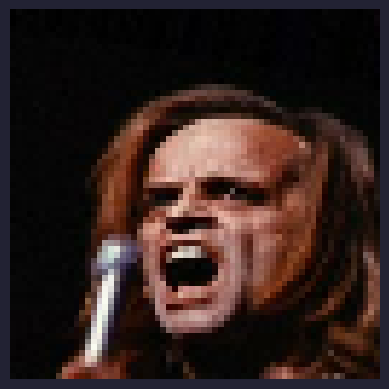

In [51]:

for data in dataset:
    plt.axis("off")
    plt.imshow((data.numpy() * 255).astype("int32")[0])

    break


## Create the discriminator

It maps a 64x64 image to a binary classification score.

In [52]:
#Building a Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

#discriminator.summary()

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [53]:
latent_dim = 128
g_resolution=2

#Building a Generator
generator = Sequential()
generator.add(Dense(4*4*256,activation="relu",input_dim=latent_dim))
generator.add(Reshape((4,4,256)))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))#
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(3,kernel_size=3,padding="same"))
generator.add(Activation("tanh"))

#generator.summary()

## Override `train_step`

In [54]:
#Code Sourced from keras sample.

class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

## Create a callback that periodically saves generated images

## Train the end-to-end model



Calling the above created GAN function trains the generator and discriminator simultaneously. To implement the GAN we must define:

Number of epochs The optimizers for Generator and Discriminator The cross-entropy loss After defing optimizers and numbers of epochs, We will define, compile and fit the model

In [55]:
#Defining the number of epochs
epochs = 5 # In practice, use ~200 epochs
#The optimizers for Generator and Discriminator
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
#To compute cross entropy loss
loss_fn = tf.keras.losses.BinaryCrossentropy()

#Defining GAN Model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#Compiling GAN Model
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#Fitting the GAN
history = model.fit(data, epochs=epochs)

Epoch 1/5
1/1 [==============================] - 22s 22s/step - d_loss: 0.6965 - g_loss: 0.6910
Epoch 2/5
1/1 [==============================] - 15s 15s/step - d_loss: 0.6876 - g_loss: 0.6725
Epoch 3/5
1/1 [==============================] - 14s 14s/step - d_loss: 0.6889 - g_loss: 0.6857
Epoch 4/5
1/1 [==============================] - 16s 16s/step - d_loss: 0.6780 - g_loss: 0.7250
Epoch 5/5
1/1 [==============================] - 14s 14s/step - d_loss: 0.6675 - g_loss: 0.7500


In [56]:
#Number of images to be generate
num_img=1

#A function to generate and save images
def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("uretileyahayaaits{:02d}.png".format(i))
    return

#Generating images
Images = Potrait_Generator()

Some of the last generated images around epoch 30
(results keep improving after that):

![results](https://i.imgur.com/h5MtQZ7l.png)

# Örnek çalışması bitti

## Şimdi veri setimizi değiştirelim

**Dataset Erişim İşlemleri** :bu kısımda datasetimizi indirme işlemleri yapıyoruz.(3GB) boyutlu yağlı boya portreleri

In [65]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'art-portraits:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1698586%2F2782287%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240507%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240507T110621Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D38a69bfa4abf986d67ed5ea5805735ea9bbd817501fde0541cb89281681f0aae83a48d76b8e5c992a970b1081265e2043efa42e4b1abc48f773bf685003c4ea465ec02517c3b63c0d40c6f41d0b9a1f64706d041098f863b36e8946905852504aa283baab6b225c30b168687040e8bda9b467bef32583c01947dcd0a11aeb1237040ee2a2f9729620d354595bf117b2b09137ceb190ab430c0af2639367e5032fbd09de528b2378a7fcba0ca68236f2c9ba2beafc1ab2cf50686bf6aa77d215ff2e6c8b6448dd9cca9c69a65d38a6391a642e784fce0c2a44d1f3b671cda06b3e9f46da160100af821a7e5322f744200f00b9388fe16e638bd49cf1a6e2b5110'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1397698045 bytes downloaded
Downloaded and uncompressed: art-portraits
Data source import complete.


In [66]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk("../input/art-portraits/Portraits/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
np.random.seed(42)

../input/art-portraits/Portraits/4a4acee3b485b653e274b790b70981a6c.jpg
../input/art-portraits/Portraits/f8b7c31610f344b727f5f6e1b0a5d7f7c.jpg
../input/art-portraits/Portraits/5a8d03ed23fbd03a906f0ff618b0c04fc.jpg
../input/art-portraits/Portraits/4e47111d4b6278fa680add8e32fc5f1fc.jpg
../input/art-portraits/Portraits/b2146e9ea70a9116f8bbd9f7e2c07543c.jpg
../input/art-portraits/Portraits/2c9d41619c9d7c9f3805a5c4f2855230c.jpg
../input/art-portraits/Portraits/c1400ea52a6006a54f3422cbdbc0ab3dc.jpg
../input/art-portraits/Portraits/e51ae1a80f7a10fdd1017a4ee50c2f79c.jpg
../input/art-portraits/Portraits/e26da999d0b8560941d12dcc5bdde924c.jpg
../input/art-portraits/Portraits/6c68ae82887efc35177c03fc8cd9a3adc.jpg
../input/art-portraits/Portraits/f647bef85618ad016bb95efc2d44053cc.jpg
../input/art-portraits/Portraits/c5d2f6efeadf4a4ba9146f0aeb4b722cc.jpg
../input/art-portraits/Portraits/4f88debe2930ca321e9431565a9c810dc.jpg
../input/art-portraits/Portraits/fee4fa6d0dfebd6dfa3017ba0d651277c.jpg
../inp

DATA LOADDING

In [67]:

import tensorflow  as tf
import matplotlib.pyplot as plt

In [68]:
#Importing data
data_path = "../input/art-portraits/Portraits/"
batch_s = 64
#Import as tf.Dataset
data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 4117 files belonging to 1 classes.


Dataseti Görüntüleme


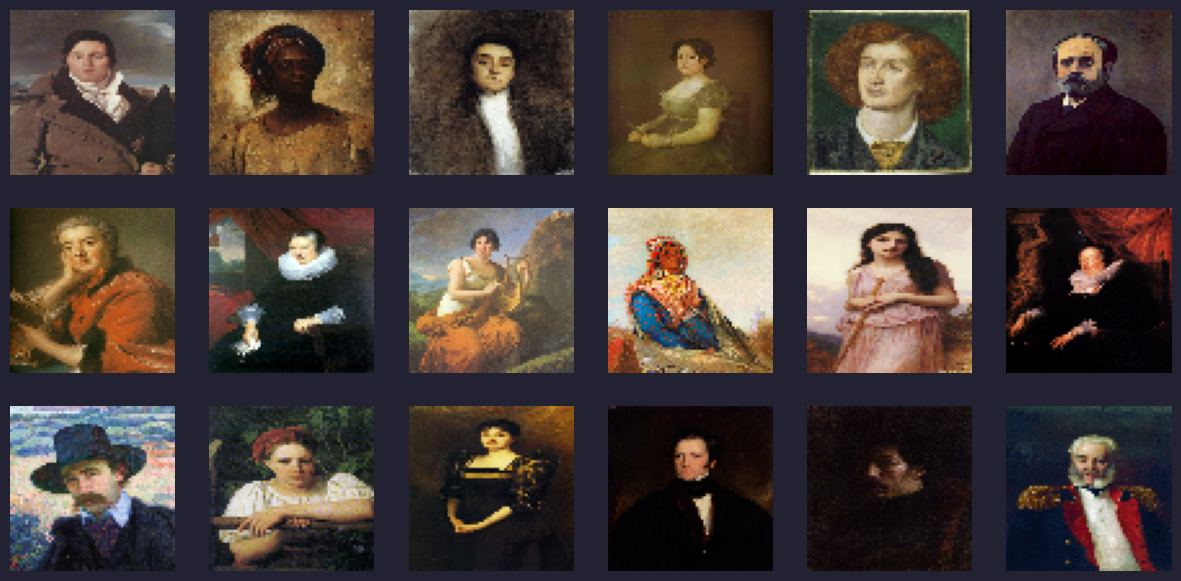

In [70]:
#Defing a function to see images
def Show_Img(data):
    plt.figure(figsize=(15,15))
    for images in data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")
#Plotting the images in dataset
Show_Img(data)

**Normalization:** For the data normalization, I will convert the data in the range between 0 to 1. This helps in fast convergence and makes it easy for the computer to do calculations faster. Each of the three RGB channels in the image can take pixel values ranging from 0 to 256. Dividing it by 255 converts it to a range between 0 to 1. By doing this we



In [71]:
#Preprocessing the dataset for model
data = data.map(lambda x: x / 255.0)
data

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

Build Generator

In [72]:
latent_dim = 100
g_resolution=2

#Building a Generator
generator = Sequential()
generator.add(Dense(4*4*256,activation="relu",input_dim=latent_dim))
generator.add(Reshape((4,4,256)))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))#
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(3,kernel_size=3,padding="same"))
generator.add(Activation("tanh"))

generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4096)              413696    
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d_8 (UpSamplin  (None, 8, 8, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization_16 (Ba  (None, 8, 8, 256)         1024      
 tchNormalization)                                               
                                                                 
 activation_10 (Activation)  (None, 8, 8, 256)        

# **Now** that the Generator is framed, let us see what random output our untrained Generator produces to get an idea of the process.

Generator oluştu ama eğitilmedi henüz bakalım ne oluşturacak

(-0.5, 63.5, 63.5, -0.5)

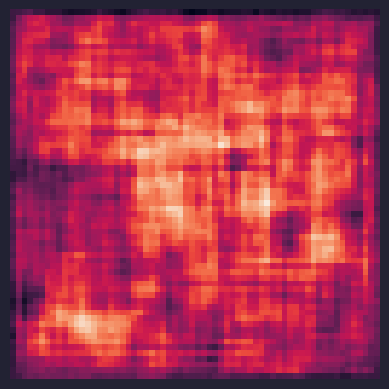

In [73]:
#Creating a random seed and output from generator
seed = tf.random.normal([1, latent_dim])
Generated_Portrait = generator(seed, training=False)
#Plotting the image output of generator without training
plt.imshow(Generated_Portrait[0, :, :, 0])
plt.axis("off")

# **The Discriminator**

In [74]:
#Building a Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 dropout_10 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d_2 (ZeroPadd  (None, 17, 17, 64)        0         
 ing2D)                                                          
                                                                 
 batch_normalization_20 (Ba  (None, 17, 17, 64)        256       
 tchNormalization)                                    

In [75]:
#for the random image generated
Discriminator_Verdict = discriminator(Generated_Portrait)
print (Discriminator_Verdict)

tf.Tensor([[0.5002274]], shape=(1, 1), dtype=float32)


The output of the discriminator i.e. The Verdict, Says that there is almost a fifty-fifty chance of the image being real. This is so because the Discriminator is not yet trained. So basically, An untrained Generarator generated some pixel-noise and the untrained Discriminator classified it as "can't tell". So far we are on a right track.

Let us proceed and build the GAN architecture to train.EVALUATING THE MODEL
Now that I have my model trained, let us see how it performs. Having a look at the performance of the model via Learning Curves

Ploting the Learning Curves

# Model Oluşumu

GAN eğitimi iki bölümden oluşur:

Bölüm 1: Discriminator eğitilirken Generator boşta durur. Discriminator gerçek görüntüler ve rastgele gürültüye (eğitilmemiş bir üreticiden) eğitilir. Bu, sahte ve gerçek arasındaki farkı belirlemesini sağlar. Bu, discriminatorün sahte olarak tahmin yapmasına uygun hale getirir.

Bölüm 2: Discriminator boşta dururken Generator eğitilir. Bu bölümde, üretici eğitilir. Discriminator eğitildikten sonra, bu adım discriminatorün tahminlerini kullanır. Üreticinin, discriminatorü aldatmaya çalışmak için ağırlıkları ayarlamasına izin verir.

Yukarıdaki yöntem birkaç epoch için tekrarlanır.

Bir sonraki bölümde, GAN eğitimi tanımlanır.

In [76]:
#Code Sourced from keras sample. find the link in the Resorces below

class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

# TRAINING THE MODEL

Calling the above created GAN function trains the generator and discriminator simultaneously. To implement the GAN we must define:

Number of epochs The optimizers for Generator and Discriminator The cross-entropy loss After defing optimizers and numbers of epochs, We will define, compile and fit the model.

In [77]:
#Defining the number of epochs
epochs = 1#~200 olmali
#The optimizers for Generator and Discriminator
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
#To compute cross entropy loss
loss_fn = tf.keras.losses.BinaryCrossentropy()

#Defining GAN Model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#Compiling GAN Model
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#Fitting the GAN
history = model.fit(data, epochs=epochs)

20/65 [========>.....................] - ETA: 22:12 - d_loss: 0.6846 - g_loss: 0.7234

KeyboardInterrupt: 

# TRAIN OVER
Now that I have my model trained, let us see how it performs. Having a look at the performance of the model via Learning Curves

Ploting the Learning Curves

In [ ]:
pal=["#994F5F","#E2AB30"]
#Plotting the learning curve
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
ax=sns.lineplot(data=history_df, palette= pal)
ax.set(xlabel ="Epochs")
ax.set(ylabel ="Loss")
ax.set_title("Learning Curve")

# To get the art output

Let us get some portraits done by the GAN and appreciate the art created by this AI. To get the art output I will create a function that saves the output portraits generated. We will be plotting the generated Portraits

AI makes Artwork

In [ ]:
#Number of images to be generate
num_img=1

#A function to generate and save images
def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("/content/datasettensonuretilen{:02d}.png".format(i))
    return

#Generating images
Images = Potrait_Generator()

###**Mustafa Özcan**






###**Yunus Emre Yılmaz**






###**Hatice Turan**






###**Yahya Haliloğlu**




